In [1]:
from yamlscript_histdata import histdata_parser
import mplhep as hep
import matplotlib.pyplot as plt
import pandas as pd
import boost_histogram as bh
import numpy as np
import logging

In [2]:
df1, df2 = histdata_parser("CR_ttc_prefit.yaml")

histdata_parser ran in 34 ms.


In [3]:
# df1

In [4]:
def latex_converter(input_obj):

    # to convert one string
    if isinstance(input_obj, str):
        return '$' + input_obj.replace('#', '\\') + '$'

    # to convert a df column
    else:
        return '$' + input_obj.replace('#', '\\\\', regex=True) + '$'

In [5]:
values = df1.loc[['Samples'],'Yield'][2]
edges = df2.loc[['BinEdges'],0][0]
centres = 0.5*(np.array(edges[1:]) + np.array(edges[:-1]))

hist_list = list(reversed(df1.loc[['Samples'], 'Yield'].tolist()))
total_yield = df1.loc[['Total'],'Yield'][0]
data_yield = df1.loc[['Data'],'Yield'][0]

In [6]:
histogram = bh.Histogram(bh.axis.Variable(edges))
histogram.fill(centres, weight=values)

Histogram(Variable([0, 0.2596, 0.2928, 0.3119, 0.328, 0.3417, 0.3554, 0.37, 0.3872, 0.412, 1]), storage=Double()) # Sum: 13085.293808531815

In [33]:
class EmptyPlot():
    
    def __init__(self, title=None, layout=(1,1), size=(6.4,4.8)):
        
        self.title = title
        self.layout = layout
        self.size = size
        
        ### these should be retrived from filled object -------------
        self.histlistedges = df2.loc[['BinEdges'],0][0]
        self.histlisttotal = df1.loc[['Total'],'Yield'][0]
        self.histlistdata = df1.loc[['Data'],'Yield'][0]
        self.histlistlabels = ['$' + x.replace('#', '\\') + '$' for x in df1.index.get_level_values(1).tolist()]
        ### ---------------------------------------------------------
        
        self.container1d = []
        self.container2d = []

    def create_canvas(self):
        self.fig, self.axs = plt.subplots(self.layout[0], self.layout[1], figsize=self.size, sharex=True, gridspec_kw={'height_ratios': [2,1], 'hspace': 0})
    
    def get_binedges1d(self, hist_index):
        if self.container1d: # if not empty
            return self.container1d[hist_index].axes.edges[0]
    
    def get_bincontents1d(self, hist_index):
        if self.container1d:
            return self.container1d[hist_index].values().tolist()


class PythHist1(EmptyPlot):
    
    def __init__(self, title=None, layout=(1,1), size=(6.4,4.8)):
        
        super().__init__(title, layout, size)
        self.isobjlist = False
        self.create_canvas()
        
    def fill(self, obj, **kwargs): # kwargs = boost histogram optional arguments
        self.container1d.append(obj)
        for key, arg in kwargs.items():
            setattr(self, key, arg)
        
        if isinstance(obj, list): # check if obj is a list
            self.isobjlist = True
    
    def display(self):
        if self.isobjlist: # if obj is list, stack them by default
            hep.histplot(self.container1d[0], ax=self.axs, bins=self.histlistedges, stack=True, edgecolor='k') # axs has only one value
        else:
            hep.histplot(self.container1d[0], ax=self.axs, edgecolor='k')
        self.axs.set_title(self.title)


class PythRatio(EmptyPlot):
    
    # the lower part in the ratio plot is the data divided by the total hist cont
                 
    def __init__(self, figtitle=None, titletop=None, titlebot=None, layout=(2,1), size=(4,6)):
        
        super().__init__(figtitle, layout, size)
        self.create_canvas()
        self.topfig = self.axs[0]
        self.botfig = self.axs[1]
        self.h1 = EmptyPlot(titletop, size=(2,2))
        self.h2 = EmptyPlot(titlebot, size=(2,2))
        self.ratiovalues = [i/j for i, j in zip(self.histlistdata, self.histlisttotal)]
        
    def fill(self, obj):
        self.h1.container1d.append(obj)
        self.h2.container1d.append(obj)
        
    def display(self):
        
        # top figure
        hep.histplot(self.h1.container1d[0], ax=self.topfig, bins=self.histlistedges, stack=True, fill=True, label=self.histlistlabels)
        hep.histplot(self.histlistdata, ax=self.topfig, bins=self.histlistedges, histtype='errorbar', color='k')
        self.topfig.set(xticklabels=[])  # remove the tick labels
        self.topfig.tick_params(bottom=False)  # remove the ticks
        self.topfig.set_ylim([0, 12_000])
        self.topfig.set_title(self.h1.title)
        self.topfig.legend(ncol=int(len(self.histlistlabels)/5))

        # bottom figure
        hep.histplot(self.ratiovalues, ax=self.botfig, bins=self.histlistedges, histtype='errorbar', color='k')
        self.botfig.set_ylim([0.5, 1.5])
        self.botfig.axhline(1, color='k', linestyle='--')
        self.botfig.set_title(self.h2.title)
        
        # overall figure
        self.fig.suptitle(self.title)

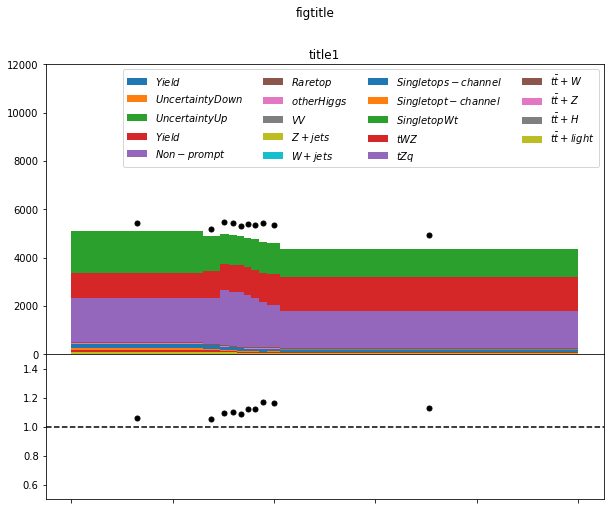

In [34]:
obj1 = PythRatio("figtitle", "title1", "", size=(10,8))
obj1.fill(hist_list)
obj1.display()

# obj2 = PythHist1("bella zi", size=(12,8))
# obj2.fill(hist_list)
# obj2.display()

# obj3 = PythHist1("ciaoooo", size=(12,8))
# obj3.fill(histogram)
# obj3.display()